# BME280: Bring up the sensor via an USB-to-I2C adapter

Date: 2021-05-30

*Important:*  
The BM**P**280 is only a pressure sensor; the BM**E**280 is the technical upgrade and additionally measures temperature and humidity!

- Data sheet: [https://raw.githubusercontent.com/rm-hull/bme280/master/doc/tech-spec/BME280.pdf](https://raw.githubusercontent.com/rm-hull/bme280/master/doc/tech-spec/BME280.pdf)
- Python library for Raspberry Pi: [https://pypi.org/project/RPi.bme280/](https://pypi.org/project/RPi.bme280/)

## Installation of required Python libraries

The installation takes place in a Python environment:
```
$ source ~/jupyter-env/bin/activate
$ pip install smbus2 RPi.bme280
```
## Installing the driver for the USB-to-I2C adapter

![USB-to-I2C adapter based on the CH341 chip](images/i2c-to-usb_ch341_kl.jpg)  
USB-to-I2C adapter based on the CH341 chip

When using a USB-to-I2C adapter based on the CH341 chip, the appropriate kernel module must be compiled and loaded.
There are 2 different implementations, but only one of them works:

- [https://github.com/allanbian1017/i2c-ch341-usb](https://github.com/allanbian1017/i2c-ch341-usb) <span style="color:green">[works]</span>
- [https://github.com/gschorcht/i2c-ch341-usb](https://github.com/gschorcht/i2c-ch341-usb) <span style="color:red">[does NOT work]</span>

### Prerequisites

To compile the driver, you must have installed current kernel header files.

Even though it is not mandatory, it is highly recommended to use DKMS (dynamic kernel module support) for the installation of the driver. DKMS allows to manage kernel modules whose sources reside outside the kernel source tree. Such modules are then automatically rebuilt when a new kernel version is installed.

To use DKMS, it has to be installed before, e.g., with following command on Debian based systems. The current kernel header files will be installed automatically.

```
# apt update
# apt install dkms
```

### Compile the kernel module and load it

```
$ mkdir ~/drivers && cd ~/drivers
$ git clone https://github.com/allanbian1017/i2c-ch341-usb.git
$ cd i2c-ch341-usb
$ make
```

### Subsequent work

Which kernel modules are loaded?

```
$ lsmod | grep -i i2c
$ lsmod | grep -i ch341
```

By default the kernel module ```ch341``` is loaded and used by the module ```usbserial```. This uses only the UART function of the CH341 chip and thus creates a conflict with I2C function. This can be recognized with the following command:

```
$dmesg

...
[  225.466832] ch341 1-1.2:1.0: ch341-uart converter detected
[  225.469053] usb 1-1.2: ch341-uart converter now attached to ttyUSB0
...
```

Therefore, this module is first unloaded and then the I2C module ```i2c-ch341-usb``` is loaded - if not already done automatically.

Unloading and loading of the modules:

```
$ sudo rmmod ch341
$ sudo insmod ~/drivers/i2c-ch341-usb/i2c-ch341-usb.ko
```

If this worked without error message ```dmesg``` should print the following:

```
...
[  551.709710] i2c_ch341_usb: loading out-of-tree module taints kernel.
[  551.710558] i2c i2c-11: connected i2c-ch341-usb device
[  551.710676] usbcore: registered new interface driver i2c-ch341-usb
...
```

### Funktion control

Now besides the Raspberry Pi's own I2C bus (```/dev/i2c-1```) another bus device file should be available (e.g. ```/dev/i2c-11```). I2C devices connected here can be recognized on the bus and used further on (here e.g. the sensor BME280 with address 0x76):

```
$ i2cdetect -y 11

     0  1  2  3  4  5  6  7  8  9  a  b  c  d  e  f
00:          -- -- -- -- -- -- -- -- -- -- -- -- -- 
10: -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
20: -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
30: -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
40: -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
50: -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
60: -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
70: -- -- -- -- -- -- 76 --
```

### Automatic unloading / loading of kernel modules at boot time (Attention: does not work yet!)

```
$ sudo nano /etc/udev/rules.d/20-i2c-usb.rules

#CH341 I2C to USB adapter
ACTION=="add", SUBSYSTEM=="i2c-dev", ATTRS{idVendor}=="1a86", ATTRS{idProduct}=="5512", RUN+="/sbin/modprobe i2c-ch341-usb"
```

Restart of the ```udev``` daemon:

```
$ sudo systemctl restart udev.service
```



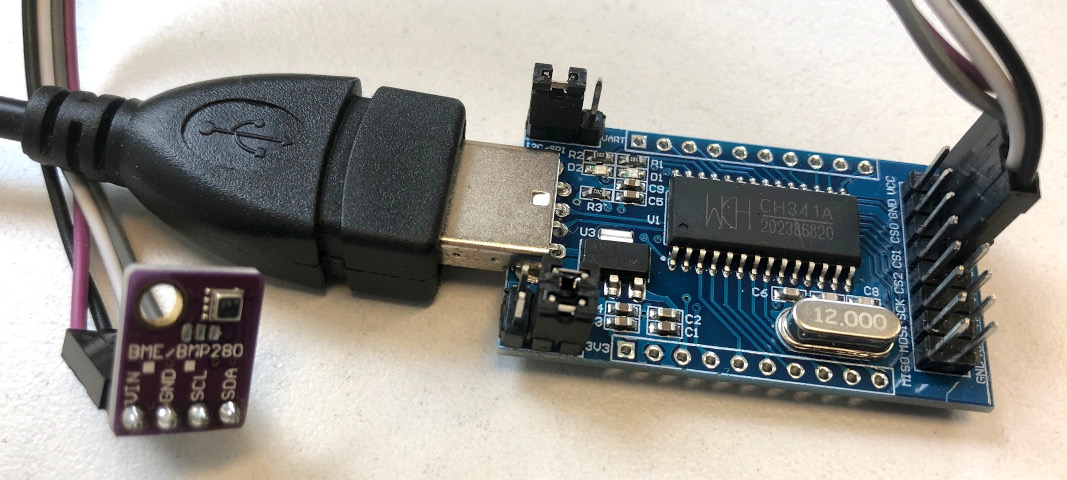

USB-to-I2C adapter based on the CH341 chip

In [17]:
from IPython.core.display import Image
from IPython.display import Markdown, display

#Image(data="./images/i2c-to-usb_ch341.jpg", width=400)
display(Image(filename="./images/i2c-to-usb_ch341_kl.jpg", width=400, embed=True))
display(Markdown("USB-to-I2C adapter based on the CH341 chip"))

![USB-to-I2C adapter based on the CH341 chip](images/i2c-to-usb_ch341_kl.jpg)  
USB-to-I2C adapter based on the CH341 chip

In [14]:
from IPython.display import Latex
Latex(r"""\begin{eqnarray}
\nabla \times \vec{\mathbf{B}} -\, \frac1c\, \frac{\partial\vec{\mathbf{E}}}{\partial t} & = \frac{4\pi}{c}\vec{\mathbf{j}} \\
\nabla \cdot \vec{\mathbf{E}} & = 4 \pi \rho \\
\nabla \times \vec{\mathbf{E}}\, +\, \frac1c\, \frac{\partial\vec{\mathbf{B}}}{\partial t} & = \vec{\mathbf{0}} \\
\nabla \cdot \vec{\mathbf{B}} & = 0 
\end{eqnarray}""")

<IPython.core.display.Latex object>

In [10]:
from IPython.display import display, Math, Latex

display(Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx'))

<IPython.core.display.Math object>

In [4]:
import smbus2
import bme280
import time

# i2c bus on /dev/i2c-11
port = 11
# i2c address of BME280
address = 0x76
bus = smbus2.SMBus(port)

INTERVAL = 1.0

calibration_params = bme280.load_calibration_params(bus, address)

#while True:
# the sample method will take a single reading and return
# a compensated_reading object
data = bme280.sample(bus, address, calibration_params)

# the compensated_reading class has the following attributes
#print(data.id)
#print(data.timestamp)
#print(data.temperature)
#print(data.pressure)
#print(data.humidity)

print("{time:s} Temperature: {temperature:.2f} °C, Pressure: {pressure:.2f} hPa, Humidity: {humidity:.2f} % rH".format(time=data.timestamp.strftime('%Y-%m-%d %H:%M:%S'), temperature=data.temperature, pressure=data.pressure, humidity=data.humidity))
    
#    time.sleep(INTERVAL)

# there is a handy string representation too
#print(data)

2021-05-29 18:52:00 Temperature: 20.11 °C, Pressure: 989.21 hPa, Humidity: 49.29 % rH


In [3]:
print(data)

compensated_reading(id=99e4bc5c-0c97-488b-b3e6-00cc0ed82e47, timestamp=2021-05-29 18:32:47.036180, temp=20.129 °C, pressure=989.22 hPa, humidity=49.81 % rH)


In [5]:
data.timestamp.strftime('%Y-%m-%d %H:%M:%S')

'2021-05-20 15:26:17'

In [14]:
import curses

In [15]:
time.time()

1562942569.8146622

In [18]:
data.timestamp.timestamp()

1562928535.463544

In [19]:
from jupyter_core.paths import jupyter_path
print(jupyter_path('nbconvert','templates'))

['/home/bk/.local/share/jupyter/nbconvert/templates', '/home/bk/jupyter-env/share/jupyter/nbconvert/templates', '/usr/local/share/jupyter/nbconvert/templates', '/usr/share/jupyter/nbconvert/templates']
